## Stack-Overflow Chatbot with text classification

Simple chatbot that uses text classification to classify input text, then returning a random StackOverflow response from the classified tag.
Build on the "Python Questions from Stack Overflow" dataset by StackOverflow on Kaggle. 
[Link to dataset](https://www.kaggle.com/datasets/stackoverflow/pythonquestions)

A trained PyTorch model is availible in the model.pth file.

The code in this notebook is based on and inspired by:

- UiA IKT 450 Lecture notes
- [Patrick Loeber PyTorch course](https://www.youtube.com/watch?v=RpWeNzfSUHw&ab_channel=PatrickLoeber)
- [PyTorch Text Tutorials and documentation](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [ ]:
import nltk
nltk.download('punkt')

In [4]:
import torch

BATCH_SIZE = 32
EPOCHS = 1000
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import nltk
import numpy as np
from nltk.stem.porter import PorterStemmer

# Tokenize each word in the sentence
def tokenize(sentence):
    return nltk.word_tokenize(sentence)

# Stem a given word
def stem(word):
    word = word.lower()
    return PorterStemmer().stem(word)

def group_words(sentence, all_words):
    sentence = [stem(w) for w in sentence]
    group = np.zeros(len(all_words), dtype=np.float32)
    
    for idx, w in enumerate(all_words):
        if w in sentence:
            group[idx] = 1.0

    return group

In [6]:
from torch.utils.data import Dataset

class RNNDataset(Dataset):

    def __init__(self, X, y):
        self.n = len(X)
        self.X = X
        self.y = y

    def __len__(self):
        return self.n

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [7]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        return x

In [8]:
import pandas as pd
import numpy

numpy.random.seed(7)

# For the purpose of this project, only include the top 30 tags
INCLUDED_TAGS = 30


# Load the tags from data/Tags.csv into a dataframe. The tags file contains the tags corresponding to each question in the Questions.csv file
df_tags = pd.read_csv("data/Tags.csv", encoding="latin1")

# Remove all tags that are "python" from the dataframe df_tags
df_tags = df_tags[df_tags['Tag'] != 'python']

# Create a list of the top 50 tags from the df_tags dataframe
top_tags = df_tags['Tag'].value_counts().head(INCLUDED_TAGS).index.tolist()

# Load the dataset from data/Questions.csv into a dataframe
df_questions = pd.read_csv("data/Questions.csv", encoding="latin1")

# Remove the column OwnerUserId, CreationDate, Score and Body from the dataframe
df_questions = df_questions.drop(columns=['OwnerUserId', 'CreationDate', 'Score', 'Body'])


all_words = []
tags = []
values = []


for tag in top_tags:
    tags.append(tag)

    # For each tag, get the questions that correspond to that tag
    df_tag = df_tags[df_tags['Tag'] == tag]

    # Merge the df_tag dataframe with the df_questions dataframe
    df_merged = pd.merge(df_tag, df_questions, left_on='Id', right_on='Id')

    # Include only the first 100 questions from the df_merged dataframe
    df_merged = df_merged.head(100)

    # Loop through each question in the df_merged dataframe
    for index, row in df_merged.iterrows():
        title = row['Title']
        words = tokenize(title)
        all_words.extend(words)
        values.append((words, tag, row['Id'], title))

ignore_words = ['?', '.', '!', ","]
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))

tags = sorted(set(tags))

X_train = []
y_train = []

for (words, tag, id, title) in values:
    group = group_words(words, all_words)
    X_train.append(group)

    label = tags.index(tag)
    y_train.append(label)


X_train = numpy.array(X_train)
X_train = torch.from_numpy(X_train)

y_train = numpy.array(y_train)
y_train = torch.from_numpy(y_train)

# Printing for debugging purposes
print(X_train.shape)
print(y_train.shape)

torch.Size([3000, 2907])
torch.Size([3000])


In [6]:
from torch.utils.data import  DataLoader

# Maybe not use this, at is spams the output console because of large number of epochs
# from tqdm import tqdm
 
dataset = RNNDataset(X_train, y_train)

dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

model = Network(len(all_words), 128, len(tags))
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):

    for (words, labels) in dataloader:
        words = words.to(DEVICE)
        labels = labels.to(DEVICE).long()

        outputs = model(words)
        # print(outputs)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the loss to a file
    with open("loss.txt", "a") as f:
        f.write(f"{loss.item()}\n")

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item()}')


print(f"Final loss: {loss.item()}")

Epoch: 0, loss: 3.3520045280456543
Epoch: 100, loss: 0.3261451721191406
Epoch: 200, loss: 1.4901152667334827e-07
Epoch: 300, loss: 0.09145792573690414
Epoch: 400, loss: 0.09064888954162598
Epoch: 500, loss: 0.1396101862192154
Epoch: 600, loss: 0.0913836807012558
Epoch: 700, loss: 0.31256532669067383
Epoch: 800, loss: 0.1751779317855835
Epoch: 900, loss: 0.17901328206062317
Final loss: 0.0


In [8]:
data = {
    "model_state": model.state_dict(),
    "input_size": len(all_words),
    "hidden_size": 128,
    "output_size": len(tags),
    "all_words": all_words,
    "tags": tags
}

torch.save(data, "model.pth")

In [9]:
tags

['arrays',
 'beautifulsoup',
 'class',
 'csv',
 'dictionary',
 'django',
 'django-models',
 'flask',
 'google-app-engine',
 'html',
 'javascript',
 'json',
 'linux',
 'list',
 'matplotlib',
 'multithreading',
 'mysql',
 'numpy',
 'pandas',
 'pyqt',
 'python-2.7',
 'python-3.x',
 'regex',
 'scipy',
 'selenium',
 'sqlalchemy',
 'string',
 'tkinter',
 'windows',
 'xml']

In [10]:
import torch

# Open saved data
data = torch.load("model.pth", map_location=torch.device(DEVICE))

model = Network(data['input_size'], data['hidden_size'], data['output_size'])
model.load_state_dict(data['model_state'])

model.eval()

print("Starting up....")
s = " "
while True:
    print("Enter 'exit' to exit")
    print("Enter a question to get a tag")
    
    s = input("Ask a question: ")
    
    # If s is exit, then exit the program
    if s == "exit":
        break
    
    # Split the sentence into words, and then group the words
    s = tokenize(s)

    # Group the words
    s = group_words(s, all_words)

    # Reshape the array to be a 2D array
    s = s.reshape(1, s.shape[0])

    # Convert the array to a tensor
    s = torch.from_numpy(s)

    # Get the output from the model
    output = model(s)

    # Get the tag with the highest probability
    _, predicted = torch.max(output, dim=1)

    # Get the tag
    tag = tags[predicted.item()]

    # Find one random element in the values list that has the same tag
    value = values[tags.index(tag)]

    print(f"Tag: {tag}")
    print(f"Question: {value[3]}")

Starting up....
Enter 'exit' to exit
Enter a question to get a tag
Tag: tkinter
Question: Re-ordering entries in a model using drag-and-drop
Enter 'exit' to exit
Enter a question to get a tag
Tag: flask
Question: Setup django with WSGI and apache
Enter 'exit' to exit
Enter a question to get a tag
Tag: flask
Question: Setup django with WSGI and apache
Enter 'exit' to exit
Enter a question to get a tag
Tag: django-models
Question: Django templates and variable attributes
Enter 'exit' to exit
Enter a question to get a tag
Tag: multithreading
Question: When to create a new app (with startapp) in Django?
Enter 'exit' to exit
Enter a question to get a tag
Tag: list
Question: Django: Print url of view without hardcoding the url
Enter 'exit' to exit
Enter a question to get a tag
Tag: list
Question: Django: Print url of view without hardcoding the url
Enter 'exit' to exit
Enter a question to get a tag
Tag: mysql
Question: Serving dynamically generated ZIP archives in Django
Enter 'exit' to exit

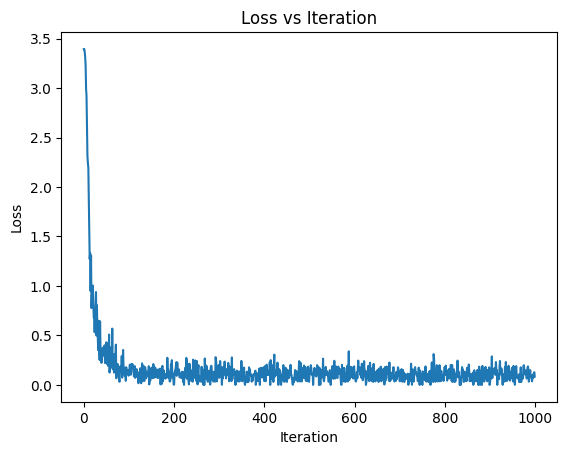

In [11]:
# Plot loss from loss.txt

import matplotlib.pyplot as plt

f = open("loss.txt", "r")

loss = []

for x in f:
    loss.append(float(x))

plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()
